# MNIST Neural Network Training Notebook

This notebook demonstrates how to build, train, and evaluate a neural network for MNIST digit recognition from scratch. The code is modular, well-commented, and includes visualization of the training progress.


In [1]:
# Adjust the Python path to include the project root if necessary

import sys
import os
# sys.path.append(os.path.join(os.path.dirname(__file__), '..'))

import numpy as np
import matplotlib.pyplot as plt

# Import dataset module and neural network components
from src.dataset.dataset import load_and_preprocess_mnist
from src.neuralnet.network import NeuralNetwork
from src.neuralnet.layers import Dense
from src.neuralnet.activations import relu, relu_derivative, softmax
from src.neuralnet.losses import cross_entropy_loss, cross_entropy_loss_derivative
from src.neuralnet.utils import one_hot_encode


## Load and Preprocess the MNIST Dataset

We load the raw MNIST data, preprocess the images (normalization and reshaping), and split the data into training, validation, and test sets. Labels are one-hot encoded for use with the cross-entropy loss.


In [2]:
# Define the data directory (adjust the path as needed)
data_dir = os.path.join(os.getcwd(), "../data/mnist")

# Load dataset using the provided module
train_images_all, train_labels_all, test_images, test_labels = load_and_preprocess_mnist(data_dir)

# Split training data into training and validation sets (90% training, 10% validation)
split_index = int(0.9 * train_images_all.shape[0])
train_images = train_images_all[:split_index]
train_labels = train_labels_all[:split_index]
val_images = train_images_all[split_index:]
val_labels = train_labels_all[split_index:]

# One-hot encode the labels for training, validation, and test sets
num_classes = 10
train_labels_encoded = one_hot_encode(train_labels, num_classes)
val_labels_encoded = one_hot_encode(val_labels, num_classes)
test_labels_encoded = one_hot_encode(test_labels, num_classes)

print("Training images shape:", train_images.shape)
print("Validation images shape:", val_images.shape)
print("Test images shape:", test_images.shape)


Training images shape: (54000, 784)
Validation images shape: (6000, 784)
Test images shape: (10000, 784)


## Define the Neural Network Architecture

We create a simple two-layer neural network:
- **Hidden layer:** 128 neurons with ReLU activation.
- **Output layer:** 10 neurons with softmax activation for 10 classes.

In [3]:
# Define the network layers
layer1 = Dense(784, 128, activation_func=relu, activation_deriv=relu_derivative)
layer2 = Dense(128, 10, activation_func=softmax, activation_deriv=None)

# Initialize the neural network with the layers and loss functions
network = NeuralNetwork(
    layers=[layer1, layer2],
    loss=cross_entropy_loss,
    loss_derivative=cross_entropy_loss_derivative
)


## Training the Neural Network

The training loop performs:
- **Forward pass:** Computes the network output.
- **Loss calculation:** Uses cross-entropy loss.
- **Backward pass:** Computes gradients and updates weights.
- **Validation:** Evaluates the network on the validation set at each epoch.

We record the training and validation losses for visualization.


In [4]:
# Training hyperparameters
epochs = 700
learning_rate = 0.01

# Lists to store loss values for plotting
train_losses = []
val_losses = []

def compute_accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Compute classification accuracy.

    Args:
        y_true (np.ndarray): True labels (as integers).
        y_pred (np.ndarray): Predicted probabilities from the network.

    Returns:
        float: Accuracy as a percentage.
    """
    predictions = np.argmax(y_pred, axis=1)
    accuracy = np.mean(predictions == y_true) * 100
    return accuracy

# Training loop
for epoch in range(epochs):
    # Forward pass on training data
    train_output = network.forward(train_images)
    train_loss = cross_entropy_loss(train_labels_encoded, train_output)
    train_losses.append(train_loss)

    # Backward pass and update weights
    network.backward(train_images, train_labels_encoded, train_output)
    for layer in network.layers:
        if hasattr(layer, 'update_params'):
            layer.update_params(learning_rate)

    # Evaluate on validation data
    val_output = network.forward(val_images)
    val_loss = cross_entropy_loss(val_labels_encoded, val_output)
    val_losses.append(val_loss)
    val_accuracy = compute_accuracy(val_labels, val_output)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


Epoch 1/700 - Train Loss: 2.3039, Val Loss: 2.3036, Val Accuracy: 6.98%
Epoch 2/700 - Train Loss: 2.3038, Val Loss: 2.3035, Val Accuracy: 7.27%
Epoch 3/700 - Train Loss: 2.3037, Val Loss: 2.3034, Val Accuracy: 7.58%
Epoch 4/700 - Train Loss: 2.3036, Val Loss: 2.3033, Val Accuracy: 7.92%
Epoch 5/700 - Train Loss: 2.3035, Val Loss: 2.3032, Val Accuracy: 8.20%
Epoch 6/700 - Train Loss: 2.3033, Val Loss: 2.3031, Val Accuracy: 8.70%
Epoch 7/700 - Train Loss: 2.3032, Val Loss: 2.3030, Val Accuracy: 8.98%
Epoch 8/700 - Train Loss: 2.3031, Val Loss: 2.3028, Val Accuracy: 9.37%
Epoch 9/700 - Train Loss: 2.3030, Val Loss: 2.3027, Val Accuracy: 9.80%
Epoch 10/700 - Train Loss: 2.3029, Val Loss: 2.3026, Val Accuracy: 10.15%
Epoch 11/700 - Train Loss: 2.3028, Val Loss: 2.3025, Val Accuracy: 10.53%
Epoch 12/700 - Train Loss: 2.3027, Val Loss: 2.3024, Val Accuracy: 10.83%
Epoch 13/700 - Train Loss: 2.3026, Val Loss: 2.3023, Val Accuracy: 11.25%
Epoch 14/700 - Train Loss: 2.3025, Val Loss: 2.3022, Val

## Visualize Training Progress

The plot below shows the training and validation loss over epochs, which helps us monitor the network's learning progress.


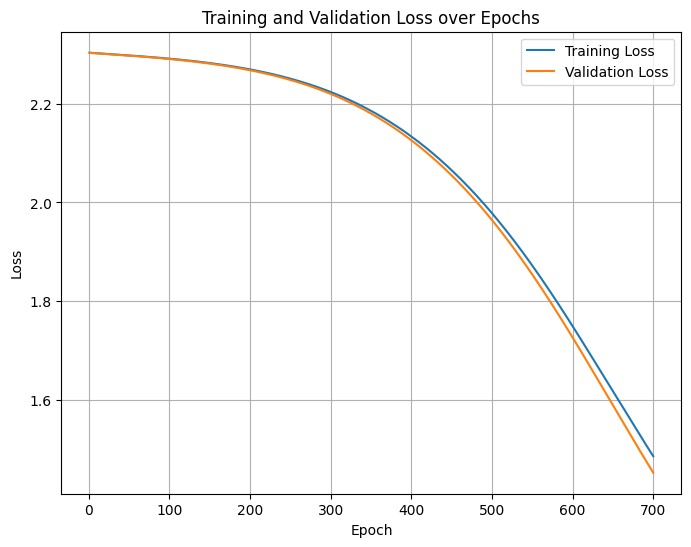

In [5]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


## Evaluate the Trained Network on the Test Set

We now evaluate the network on the test set to measure its performance using the test loss and accuracy.


In [6]:
# Evaluate on the test set
test_output = network.forward(test_images)
test_loss = cross_entropy_loss(test_labels_encoded, test_output)
test_accuracy = compute_accuracy(test_labels, test_output)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 1.4648, Test Accuracy: 69.83%


## Visualize Some Test Predictions

Below, we display a few random test images along with their predicted and true labels.


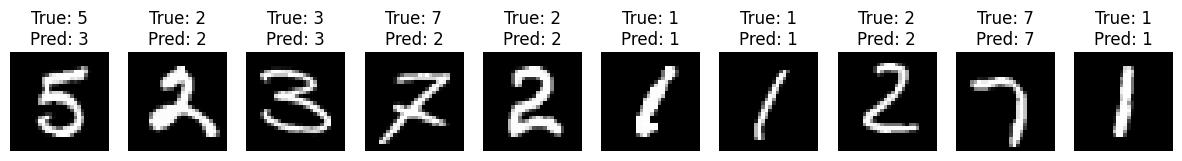

In [7]:
import random

num_display = 10
indices = random.sample(range(test_images.shape[0]), num_display)
sample_images = test_images[indices]
sample_labels = test_labels[indices]
sample_output = network.forward(sample_images)
predicted_labels = np.argmax(sample_output, axis=1)

plt.figure(figsize=(15, 4))
for i, idx in enumerate(indices):
    plt.subplot(1, num_display, i+1)
    # Reshape the flattened image back to 28x28 for display
    plt.imshow(test_images[idx].reshape(28, 28), cmap='gray')
    plt.title(f"True: {sample_labels[i]}\nPred: {predicted_labels[i]}")
    plt.axis('off')
plt.show()


## Conclusion

In this notebook, we built a neural network from scratch, trained it on the MNIST dataset, and visualized the training progress and test predictions. The modular design of the code allows for easy extensions and reuse in future projects.
